<a href="https://colab.research.google.com/github/kimjeongsoo20190147/bank_transaction_fraud_detation/blob/main/bank_transaction_fraud_detaction_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

train_transaction: (590540, 393)
train_identity: (144233, 40)
test_transaction: (506691, 392)
test_identity: (141907, 40)
Train shape (merged): (590540, 433)
Test  shape (merged): (506691, 432)
X_all shape: (590540, 432)
X_test shape: (506691, 432)
y_all shape: (590540,)
X_train: (472432, 432) X_val: (118108, 432)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



=== Confusion Matrix ===
[[113841    134]
 [  2016   2117]]


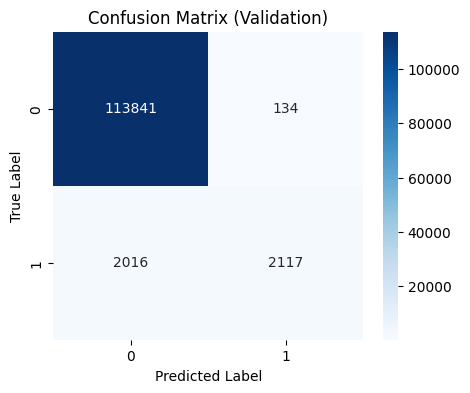


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9826    0.9988    0.9906    113975
           1     0.9405    0.5122    0.6632      4133

    accuracy                         0.9818    118108
   macro avg     0.9615    0.7555    0.8269    118108
weighted avg     0.9811    0.9818    0.9792    118108



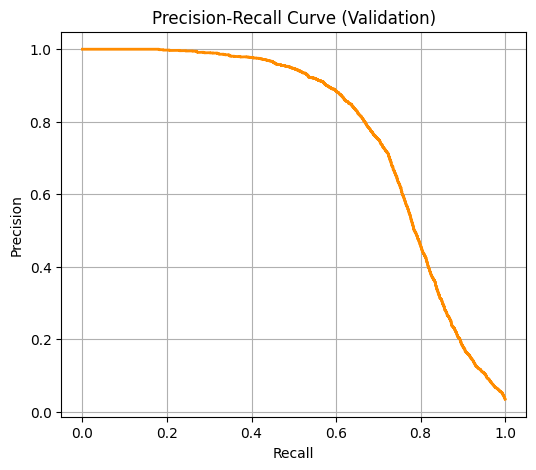

Done! Submission file saved: simple_xgboost_plt.csv


In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

#############################
# 1) 데이터 불러오기
#############################
train_transaction = pd.read_csv('/content/train_transaction.csv', index_col='TransactionID')
train_identity    = pd.read_csv('/content/train_identity.csv',    index_col='TransactionID')

test_transaction  = pd.read_csv('/content/test_transaction.csv',  index_col='TransactionID')
test_identity     = pd.read_csv('/content/test_identity.csv',     index_col='TransactionID')

sample_submission = pd.read_csv('/content/sample_submission.csv', index_col='TransactionID')

print("train_transaction:", train_transaction.shape)
print("train_identity:", train_identity.shape)
print("test_transaction:", test_transaction.shape)
print("test_identity:", test_identity.shape)

#############################
# 2) 컬럼명 치환 ( '-' → '_' )
#############################
train_transaction.columns = [c.replace('-', '_') for c in train_transaction.columns]
train_identity.columns    = [c.replace('-', '_') for c in train_identity.columns]
test_transaction.columns  = [c.replace('-', '_') for c in test_transaction.columns]
test_identity.columns     = [c.replace('-', '_') for c in test_identity.columns]

#############################
# 3) Train 병합, Test 병합
#############################
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test  = test_transaction.merge(test_identity,   how='left', left_index=True, right_index=True)

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

print("Train shape (merged):", train.shape)
print("Test  shape (merged):", test.shape)

#############################
# 4) 타깃 분리
#############################
y_all = train['isFraud'].copy()
X_all = train.drop('isFraud', axis=1)

# 테스트 세트
X_test = test.copy()

del train, test
gc.collect()

#############################
# 5) 간단한 결측치 처리
#############################
X_all  = X_all.fillna(-999)
X_test = X_test.fillna(-999)

#############################
# 6) 라벨 인코딩
#############################
for col in X_all.columns:
    if X_all[col].dtype == 'object' or X_test[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(X_all[col].values) + list(X_test[col].values))
        X_all[col]  = le.transform(X_all[col].values)
        X_test[col] = le.transform(X_test[col].values)

print("X_all shape:", X_all.shape)
print("X_test shape:", X_test.shape)
print("y_all shape:", y_all.shape)

#############################
# 7) Train/Validation 분할
#############################
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)

#############################
# 8) 모델 학습 (검증 지표 확인용)
#############################
clf = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.4,
    missing=-999,
    random_state=42,
    # XGBoost 2.0+에서 GPU 사용 시
    tree_method='hist',
    device='cuda'
)

clf.fit(X_train, y_train)

#############################
# 9) 검증 세트 예측 → 혼동행렬, 정밀도/재현율, PR 커브
#############################
# (1) 0/1 예측
y_val_pred = clf.predict(X_val)

# (2) 혼동행렬
cm = confusion_matrix(y_val, y_val_pred)
print("\n=== Confusion Matrix ===")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# (3) 정밀도/재현율 리포트
print("\n=== Classification Report ===")
print(classification_report(y_val, y_val_pred, digits=4))

# (4) Precision-Recall Curve (검증 세트 확률 예측 사용)
y_val_proba = clf.predict_proba(X_val)[:, 1]  # 사기(1) 확률
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.title("Precision-Recall Curve (Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

#############################
# 10) 최종 전체 학습 & 제출 파일 생성
#############################
# (선택) 만약 검증 점수가 괜찮다면, 전체 데이터를 사용해 재학습
final_model = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.4,
    missing=-999,
    random_state=42,
    tree_method='hist',
    device='cuda'
)
final_model.fit(X_all, y_all)

# 테스트 세트 예측
y_test_proba = final_model.predict_proba(X_test)[:, 1]
sample_submission['isFraud'] = y_test_proba

sample_submission.to_csv('simple_xgboost_plt.csv')
print("Done! Submission file saved: simple_xgboost_plt.csv")
